In [95]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from operator import itemgetter
import pickle
from scipy.stats import skew, boxcox
from datetime import datetime
import matplotlib.pyplot as plt
#import plotly.plotly as py
#py.sign_in('rezaul_abedin', 'Abedin228')
#import plotly.graph_objs as go
from sklearn.model_selection import learning_curve, GridSearchCV
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from sklearn.metrics import make_scorer
import time
start = time.clock()
print('Started!')

Started!


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [96]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print(' Time taken: %i minutes and %s seconds.' %
              (tmin, round(tsec, 2)))


In [3]:
def get_date_features():
    pkl_file = open('D:/Project/Sample data/train_date_df/train_date_df.pkl', 'rb')
    traindata = pickle.load(pkl_file)
        
    return ['Id'] + list(traindata.columns)
        
usefuldatefeatures = get_date_features()


In [4]:
usefuldatefeatures

['Id',
 'L0_S0_D1',
 'L0_S0_D3',
 'L0_S0_D5',
 'L0_S0_D7',
 'L0_S0_D9',
 'L0_S0_D11',
 'L0_S0_D13',
 'L0_S0_D15',
 'L0_S0_D17',
 'L0_S0_D19',
 'L0_S0_D21',
 'L0_S0_D23',
 'L0_S1_D26',
 'L0_S1_D30',
 'L0_S2_D34',
 'L0_S2_D38',
 'L0_S2_D42',
 'L0_S2_D46',
 'L0_S2_D50',
 'L0_S2_D54',
 'L0_S2_D58',
 'L0_S2_D62',
 'L0_S2_D66',
 'L0_S3_D70',
 'L0_S3_D74',
 'L0_S3_D78',
 'L0_S3_D82',
 'L0_S3_D86',
 'L0_S3_D90',
 'L0_S3_D94',
 'L0_S3_D98',
 'L0_S3_D102',
 'L0_S4_D106',
 'L0_S4_D111',
 'L0_S5_D115',
 'L0_S5_D117',
 'L0_S6_D120',
 'L0_S6_D124',
 'L0_S6_D127',
 'L0_S6_D130',
 'L0_S6_D134',
 'L0_S7_D137',
 'L0_S7_D139',
 'L0_S7_D140',
 'L0_S7_D141',
 'L0_S7_D143',
 'L0_S8_D145',
 'L0_S8_D147',
 'L0_S8_D148',
 'L0_S8_D150',
 'L0_S9_D152',
 'L0_S9_D157',
 'L0_S9_D162',
 'L0_S9_D167',
 'L0_S9_D172',
 'L0_S9_D177',
 'L0_S9_D182',
 'L0_S9_D187',
 'L0_S9_D192',
 'L0_S9_D197',
 'L0_S9_D202',
 'L0_S9_D207',
 'L0_S9_D212',
 'L0_S10_D216',
 'L0_S10_D221',
 'L0_S10_D226',
 'L0_S10_D231',
 'L0_S10_D236',
 'L0

In [36]:
def get_date():
    ## get the data plus do some feature engineering
    trainfile = 'D:/Project/Sample data/Sam_8/train_date.csv'# without mean
    testfile = 'D:/Project/Sample data/Sam_test_8/test_date.csv'# without mean
 
    train = pd.read_csv(trainfile, usecols=usefuldatefeatures)
    features = list(train.columns)
    features.remove('Id')
    df_train = train[['Id']].copy()
    df_train['mindate'] = train[features].min(axis=1).values
    
    #print (train[features].min(axis=1).values)
    #print (df_train.head())
    
    df_train['maxdate'] = train[features].max(axis=1).values 
    #print (df_train.head())
    df_train['diff'] = df_train['maxdate'] - df_train['mindate']    
    
    #print (df_train.head())
        
    test = pd.read_csv(testfile, usecols=usefuldatefeatures)
    df_test = test[['Id']].copy()
    df_test['mindate'] = test[features].min(axis=1).values
    df_test['maxdate'] = test[features].max(axis=1).values 
    df_test['diff'] = df_test['maxdate'] - df_test['mindate']
        
    df = pd.concat([df_train, df_test])     
    df.sort_values(by=['mindate', 'Id'], inplace=True)
    
    #print(df.head())
    
    df['df_id_diff'] = df.Id.diff()
    #print(df.Id.diff())
    rew = np.full_like(df.df_id_diff.values, np.nan)
    #print(rew)
    rew[0:-1] = -df.df_id_diff.values[1:]
    #print (df.df_id_diff.values[1:])
    df['df_id_diff_reverse'] = rew
        
    return df

In [37]:
date_pros = get_date()

In [38]:
date_pros

,Id,mindate,maxdate,diff,df_id_diff,df_id_diff_reverse
3616,1060450,0.09,1.48,1.39,NaN,-195631.0
4265,1256081,0.29,1.68,1.39,195631.0,784399.0
1627,471682,0.39,0.46,0.07,-784399.0,377088.0
324,94594,0.41,1.62,1.21,-377088.0,-381493.0
1613,476087,0.41,1.63,1.22,381493.0,325086.0
532,151001,0.43,1.59,1.16,-325086.0,-431925.0
1960,582926,0.47,0.51,0.04,431925.0,-1008321.0
5350,1591247,0.52,1.73,1.21,1008321.0,103192.0
5079,1488055,0.60,1.38,0.78,-103192.0,-292243.0
5972,1780298,0.61,1.05,0.44,292243.0,611695.0


In [14]:
'''def cat_date_preprosess(visible, blind, column_name):
    outcomes = visible.groupby(column_name)['Response'].mean().reset_index()
    x = pd.merge(blind[[column_name, 'Response']], outcomes,
                 suffixes=('_', ''),
                 how='left',
                 on=column_name,
                 left_index=True)['Response']
    return x.fillna(x.mean())
'''

In [89]:
def data():
   #trainfiles = ['D:/Project/Sample data/Sam_8/train_categorical.csv']
    trainfiles = ['D:/Project/Sample data/Sam_8/train_categorical.csv','D:/Project/Sample data/Sam_8/train_date.csv','D:/Project/Sample data/Sam_8/train_numeric.csv']
    #testfiles = ['D:/Project/Sample data/Sam_Test_8/test_categorical.csv']

    testfiles = ['D:/Project/Sample data/Sam_Test_8/test_categorical.csv','D:/Project/Sample data/Sam_Test_8/test_date.csv', 'D:/Project/Sample data/Sam_Test_8/test_numeric.csv']

    cols = [['Id',
             'L1_S24_F1559', 'L3_S32_F3851',
             'L1_S24_F1827', 'L1_S24_F1582',
             'L3_S32_F3854', 'L1_S24_F1510',
             #'L1_S24_F1525', 
             'L3_S29_F3481',
             'L2_S26_F3097', 'L2_S27_F3220',
             'L2_S27_F3192', 'L3_S29_F3493',
             #'L1_S24_F675', 
             'L3_S47_F4191',
            ],
            ['Id',
             'L3_S30_D3496', 'L3_S30_D3506',
             'L3_S30_D3501', 'L3_S30_D3516',
             'L3_S30_D3511', 'L3_S37_D3951',
             'L3_S34_D3883', 'L3_S47_D4190',
             'L3_S38_D3961', 'L3_S32_D3852',
             'L3_S29_D3480', 'L0_S4_D106',
             'L0_S3_D102',   'L3_S35_D3891',
             'L0_S1_D26',    #'L0_S21_D484',
             'L3_S36_D3940', 'L0_S16_D428', 
             'L3_S33_D3874', 'L3_S36_D3925',
             'L2_S26_D3096', 'L2_S27_D3219',
             'L0_S0_D23',    'L3_S29_D3492',
             'L0_S11_D328',  'L0_S10_D231', 

            ],
            ['Id',
             'L1_S24_F1846', 'L3_S32_F3850',
             'L1_S24_F1695', 'L1_S24_F1632',
             'L3_S33_F3855', 'L1_S24_F1604',
             'L3_S29_F3407', 'L3_S33_F3865',
             'L3_S38_F3952', 'L1_S24_F1723',
             'L3_S38_F3960', 'L3_S33_F3865', 
             'L3_S38_F3956', 'L3_S33_F3857',
             'L3_S29_F3321', 'L1_S24_F1846', 
             'L3_S29_F3354', 'L3_S29_F3324', 
             'L3_S35_F3889', 'L0_S1_F28', 
             'L1_S24_F1844', 'L3_S29_F3376', 
             'L0_S0_F22',    'L3_S33_F3859',  
             'L3_S30_F3754', 'L2_S26_F3113', 
             'L3_S30_F3759', 'L0_S5_F114',
             'L3_S29_F3339', 'L3_S30_F3804',
             'L3_S29_F3351', 'L3_S30_F3704',   
             
             'Response',]]

    traindata = None
    testdata = None
    for i, f in enumerate(trainfiles):
        #print("i", i)
        #print("f",f)
        subset = None
        for i, chunk in enumerate(pd.read_csv(f,
                                              usecols=cols[i],
                                              chunksize=1000,
                                              low_memory=False)):
           #print("i", i)
            #print(chunk)
            if subset is None:
                subset = chunk.copy()
            else:

                subset = pd.concat([subset, chunk])
            
            #rint(subset)

            del chunk
            #print(subset)
            gc.collect()
        if traindata is None:
            traindata = subset.copy()
        else:
            traindata = pd.merge(traindata, subset.copy(), on="Id")
        del subset
        gc.collect()
  
    traindata['magic'] = traindata['L3_S33_F3855'].pct_change()
    traindata['magic2'] = traindata['L3_S29_F3407'].pct_change()
    traindata['magic5'] = traindata['L3_S29_F3354'].pct_change()
    traindata['magic6'] = traindata['L3_S29_F3321'].pct_change()
    traindata['magic7'] = traindata['L3_S38_F3952'].pct_change()
#    traindata['magic8'] = traindata['L1_S24_F1604'].pct_change()
    
#    traindata['magic9'] = traindata['L3_S33_F3859'].pct_change()
#    traindata['magic10'] = traindata['L0_S0_F22'].pct_change() 
#    traindata['magic11'] = traindata['L3_S33_F3857'].pct_change()

#    traindata['magic13'] = traindata['L3_S30_F3804'].pct_change()
#    
#    traindata['magic14'] = traindata['L3_S30_F3754'].pct_change()
#    traindata['magic15'] = traindata['L1_S24_F1844'].pct_change()
#    traindata['magic16'] = traindata['L3_S38_F3956'].pct_change()
#    traindata['magic17'] = traindata['L3_S32_F3850'].pct_change()

#    traindata['magic19'] = traindata['L3_S29_F3351'].pct_change()

    del cols[2][-1] 
    for i, f in enumerate(testfiles):
        #rint(f)
        subset = None
        for i, chunk in enumerate(pd.read_csv(f,
                                              usecols=cols[i],
                                              chunksize=1000,
                                              low_memory=False)):
            #rint(i)
            if subset is None:
                subset = chunk.copy()
            else:

                subset = pd.concat([subset, chunk]) 
                
            del chunk
            gc.collect()
        if testdata is None:
            testdata = subset.copy()
        else:
            testdata = pd.merge(testdata, subset.copy(), on="Id")
        del subset
        gc.collect()
    
    testdata['magic'] = testdata['L3_S33_F3855'].pct_change()
    testdata['magic2'] = testdata['L3_S29_F3407'].pct_change()
    testdata['magic5'] = testdata['L3_S29_F3354'].pct_change()
    testdata['magic6'] = testdata['L3_S29_F3321'].pct_change()
    testdata['magic7'] = testdata['L3_S38_F3952'].pct_change()
#    testdata['magic8'] = testdata['L1_S24_F1604'].pct_change()
    
#    testdata['magic10'] = testdata['L0_S0_F22'].pct_change() 
#    testdata['magic11'] = testdata['L3_S33_F3857'].pct_change()

#    testdata['magic13'] = testdata['L3_S30_F3804'].pct_change()
#    
#    testdata['magic14'] = testdata['L3_S30_F3754'].pct_change()
#    testdata['magic15'] = testdata['L1_S24_F1844'].pct_change()
#    testdata['magic16'] = testdata['L3_S38_F3956'].pct_change()
#    testdata['magic17'] = testdata['L3_S32_F3850'].pct_change()
#    testdata['magic19'] = testdata['L3_S29_F3351'].pct_change()
   
    traindata = traindata.merge(date_pros, on='Id')
    testdata = testdata.merge(date_pros, on='Id')    
    testdata['Response'] = 0  
    
    cols = [['Id',
             'L1_S24_F1559', 'L3_S32_F3851',
             'L1_S24_F1827', 'L1_S24_F1582',
             'L3_S32_F3854', 'L1_S24_F1510',
             #'L1_S24_F1525', 
             'L3_S29_F3481',
             'L2_S26_F3097', 'L2_S27_F3220',
             'L2_S27_F3192', 'L3_S29_F3493',
             #'L1_S24_F675',  
             'L3_S47_F4191',

            ],
            ['Id',
             'L3_S30_D3496', 'L3_S30_D3506',
             'L3_S30_D3501', 'L3_S30_D3516',
             'L3_S30_D3511', 'L3_S37_D3951',
             'L3_S34_D3883', 'L3_S47_D4190',
             'L3_S38_D3961', 'L3_S32_D3852',
             'L3_S29_D3480', 'L0_S4_D106',
             'L0_S3_D102',   'L3_S35_D3891',
             'L0_S1_D26',    #'L0_S21_D484',
             'L3_S36_D3940', 'L0_S16_D428', 
             'L3_S33_D3874', 'L3_S36_D3925',
             'L2_S26_D3096', 'L2_S27_D3219',
             'L0_S0_D23',    'L3_S29_D3492',
             'L0_S11_D328',  'L0_S10_D231', 

            ],
            ['Id',
             'L1_S24_F1846', 'L3_S32_F3850',
             'L1_S24_F1695', 'L1_S24_F1632',
             'L3_S33_F3855', 'L1_S24_F1604',
             'L3_S29_F3407', 'L3_S33_F3865',
             'L3_S38_F3952', 'L1_S24_F1723',
             'L3_S38_F3960', 'L3_S33_F3865', 
             'L3_S38_F3956', 'L3_S33_F3857',
             'L3_S29_F3321', 'L1_S24_F1846', 
             'L3_S29_F3354', 'L3_S29_F3324', 
             'L3_S35_F3889', 'L0_S1_F28', 
             'L1_S24_F1844', 'L3_S29_F3376', 
             'L0_S0_F22',    'L3_S33_F3859',  
             'L3_S30_F3754', 'L2_S26_F3113', 
             'L3_S30_F3759', 'L0_S5_F114',
             'L3_S29_F3339', 'L3_S30_F3804',
             'L3_S29_F3351',  'L3_S30_F3704',
             'Response', 'magic', 'magic2', 
             'magic5', 'magic6','magic7',
#             'magic8', 'magic9', 'magic10', 'magic11', 'magic13',
#             'magic14', 'magic15', 'magic16', 'magic17', 'magic19',
            ]]
    
    ntrain = traindata.shape[0]
    ntest = testdata.shape[0]
    train_test = pd.concat((traindata, testdata)).reset_index(drop=True)
       
    numeric_feats = \
            [
             'L1_S24_F1846', 'L3_S32_F3850',
             'L1_S24_F1695', 'L1_S24_F1632',
             'L3_S33_F3855', 'L1_S24_F1604',
             'L3_S29_F3407', 'L3_S33_F3865',
             'L3_S38_F3952', 'L1_S24_F1723',
             'L3_S38_F3960', 'L3_S33_F3865', 
             'L3_S38_F3956', 'L3_S33_F3857',
             'L3_S29_F3321', 'L1_S24_F1846', 
             'L3_S29_F3354', 'L3_S29_F3324', 
             'L3_S35_F3889', 'L0_S1_F28', 
             'L1_S24_F1844', 'L3_S29_F3376', 
             'L0_S0_F22',    'L3_S33_F3859',  
             'L3_S30_F3754', 'L2_S26_F3113', 
             'L3_S30_F3759', 'L0_S5_F114',
             'L3_S29_F3339', 'L3_S30_F3804',
             'L3_S29_F3351',  'L3_S30_F3704',
             'magic', 'magic2', 'magic5', 'magic6', 'magic7',
#             'magic8', 'magic9', 'magic10', 'magic11', 'magic13',        
#             'magic14', 'magic15', 'magic16', 'magic17', 'magic19',
    ]

    skewed_feats = train_test[numeric_feats].apply(lambda x: skew(x.dropna()))
    print("\nSkew in numeric features:")
    print(skewed_feats)
    skewed_feats = skewed_feats[np.absolute(skewed_feats) > 0.2]
    skewed_feats = skewed_feats.index
    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1000
        train_test[feats], lam = boxcox(train_test[feats])                
    
    traindata = train_test.iloc[:ntrain, :]
    testdata = train_test.iloc[ntrain:, :]
     
    return traindata, testdata



In [164]:
#if __name__ == "__main__":
    
start_time = timer(None)

train, test = data()
print('Train shape:', train.shape)
print('Test shape:', test.shape)

features = list(train.columns)
features.remove('Response')
features.remove('Id')
print(features)

X = train[features]
y = train['Response'] 
parameters = { 'n_estimators': [ 100, 150, 200],
               'objective' : ['binary:logistic'],
               'learning_rate' : [0.02, 0.05, 0.1],
               'max_depth' : [9, 10, 12, 15], 
               'base_score' : [0.0056],  
               'min_child_weight': [ 2, 4, 6],  
               'gamma' : [0, 0.2, 1],

 }
'''
def mcc(y, preds):
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc_ = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
    best_threshold = thresholds[mcc_.argmax()]
    return mcc_.max()
'''
ssscv = StratifiedKFold( n_splits=2, shuffle=True, random_state=0) # 1. Let's build a stratified shuffle object
ssscv.get_n_splits(X, y)
print ("mcc", mcc)
score = make_scorer(mcc, greater_is_better=True)
print ("score:", score)
grid = RandomizedSearchCV(XGBClassifier(),
                          param_distributions=parameters,
                          n_iter=23,
                          cv=ssscv, 
                          scoring=score,

                         ) # 2. Let's now we pass the object and the parameters to grid search
grid.fit(X, y) # 3. Let's fit it

best = grid.best_estimator_

#for params, mean_train_score in grid.cv_results_ :
    #print("%0.3f (+/-%0.3f) for %r" % (mean_train_score.mean(), mean_train_score.std(), params))
#print

import pandas as pd
cv_results = pd.DataFrame(grid.cv_results_)

print(cv_results['mean_train_score'])
print(cv_results['mean_test_score'])

for g in grid.cv_results_: print(g)

#print(grid.best_score_)
#print(grid.best_estimator_)
#print("Best params: {}".format( grid.best_params_))


#print(scores)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1031: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):



Skew in numeric features:
L1_S24_F1846   -0.115297
L3_S32_F3850   -0.097011
L1_S24_F1695    2.295745
L1_S24_F1632   -0.256862
L3_S33_F3855    0.067550
L1_S24_F1604    1.599911
L3_S29_F3407   -2.881485
L3_S33_F3865   -0.146548
L3_S38_F3952   -0.725198
L1_S24_F1723   -0.427800
L3_S38_F3960    1.387486
L3_S33_F3865   -0.146548
L3_S38_F3956   -0.036244
L3_S33_F3857    0.040891
L3_S29_F3321    0.657533
L1_S24_F1846   -0.115297
L3_S29_F3354    0.137426
L3_S29_F3324    0.535930
L3_S35_F3889    0.516382
L0_S1_F28       0.599846
L1_S24_F1844    0.079127
L3_S29_F3376    0.426489
L0_S0_F22       0.094776
L3_S33_F3859   -0.291161
L3_S30_F3754   -1.168406
L2_S26_F3113    0.083748
L3_S30_F3759    0.577946
L0_S5_F114     -0.394970
L3_S29_F3339   -0.030512
L3_S30_F3804   -3.485517
L3_S29_F3351   -0.388367
L3_S30_F3704   -0.141159
magic           0.008430
magic2         -4.807247
magic5          0.077453
magic6          3.960617
magic7         -7.739565
dtype: float64
Train shape: (8000, 79)
Test shap

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0     0.000000
1     0.363980
2     0.000000
3     0.000000
4     0.000000
5     0.846943
6     0.987279
7     0.111538
8     0.000000
9     0.000000
10    0.111538
11    0.000000
12    0.387830
13    0.524307
14    0.000000
15    0.732720
16    0.673423
17    0.387830
18    0.000000
19    0.000000
20    0.000000
21    0.694387
22    0.987279
Name: mean_train_score, dtype: float64
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.114421
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21   -0.000546
22    0.000000
Name: mean_test_score, dtype: float64
mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_objective
param_n_estimators
param_min_child_weight
param_max_depth
param_learning_rate
param_gamma
param_base_score
params
split0_test_score
split1_test_score
mean_test

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

In [161]:
#train.to_csv("D:/Project/final.csv", header= True, index=False)

In [131]:
for g in grid.cv_results_:
    
    print(g)


mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_objective
param_n_estimators
param_min_child_weight
param_max_depth
param_learning_rate
param_gamma
param_base_score
params
split0_test_score
split1_test_score
mean_test_score
std_test_score
rank_test_score
split0_train_score
split1_train_score
mean_train_score
std_train_score


In [144]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

(23, 21)

In [146]:
print(cv_results["n_estimators"])

KeyError: 'n_estimators'

In [149]:
scores = np.array([[
        cv_results['mean_train_score'],
        cv_results['param_n_estimators']]])

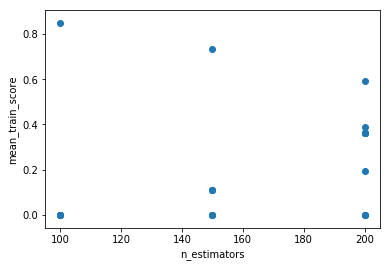

In [151]:
plt.scatter(scores[:,1], scores[:, 0])
plt.xlabel('n_estimators')
plt.ylabel('mean_train_score')
plt.show()



In [153]:
scores = np.array([[
        cv_results['mean_train_score'],
        cv_results['param_gamma']]])

Text(0, 0.5, 'mean_train_score')

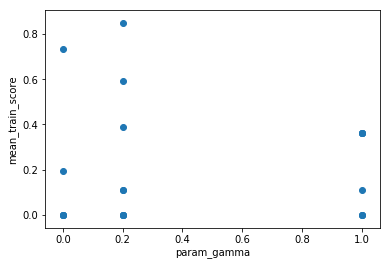

In [155]:
plt.scatter(scores[:,1], scores[:, 0])
plt.xlabel('param_gamma')
plt.ylabel('mean_train_score')

In [150]:
scores

array([[[0.36397969344181924, 0.0, 0.8469433191872511, 0.0, 0.0, 0.0,
         0.0, 0.11153754973102109, 0.0, 0.19323701838063098,
         0.36397969344181924, 0.5909924181515112, 0.38783035437756136,
         0.0, 0.0, 0.11153754973102109, 0.0, 0.36397969344181924,
         0.7327201698509269, 0.11153754973102109, 0.0,
         0.36397969344181924, 0.0],
        [200, 200, 100, 150, 150, 200, 100, 150, 100, 200, 200, 200,
         200, 150, 100, 150, 100, 200, 150, 150, 100, 200, 200]]],
      dtype=object)

In [134]:
cv_results = pd.DataFrame(grid.cv_results_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

In [143]:
print(cv_results['param_n_estimators'])

0     200
1     200
2     100
3     150
4     150
5     200
6     100
7     150
8     100
9     200
10    200
11    200
12    200
13    150
14    100
15    150
16    100
17    200
18    150
19    150
20    100
21    200
22    200
Name: param_n_estimators, dtype: object


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,3.226849,0.014582,0.273350,0.013051,binary:logistic,200,4,9,0.05,1,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.228899,0.499061,0.363980,0.135081
1,3.110677,0.252632,0.348067,0.093753,binary:logistic,200,6,12,0.02,0.2,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000
2,2.326785,0.046875,0.333136,0.063826,binary:logistic,100,2,9,0.1,0.2,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.857856,0.836030,0.846943,0.010913
3,1.970756,0.008958,0.255333,0.008960,binary:logistic,150,6,9,0.05,0.2,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000
4,2.086478,0.090705,0.234858,0.008462,binary:logistic,150,6,10,0.02,0,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000
5,2.612026,0.089764,0.253854,0.024434,binary:logistic,200,6,15,0.02,0.2,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000
6,1.640515,0.313064,0.371014,0.104725,binary:logistic,100,6,9,0.1,0,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000
7,2.164628,0.105018,0.323163,0.018921,binary:logistic,150,6,12,0.1,1,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.223075,0.111538,0.111538
8,1.981806,0.050788,0.293474,0.004245,binary:logistic,100,4,15,0.05,1,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000
9,2.388948,0.055286,0.289210,0.018933,binary:logistic,200,6,15,0.1,0,...,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.000000,0.000000,0.000000,2,0.000000,0.386474,0.193237,0.193237


In [159]:
for i in grid.scorer_:
    print(i)

TypeError: '_PredictScorer' object is not iterable